<a href="https://colab.research.google.com/github/arsan13/Data-Science/blob/main/Global_Superstore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Global Superstore Sales**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

### **Data Collection**

In [ ]:
df = pd.read_excel('/content/Global_Superstore.xlsx')

### **Analysing Data**

In [ ]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


In [ ]:
df.shape

(51290, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [ ]:
df['Category'].value_counts()

Office Supplies    31273
Technology         10141
Furniture           9876
Name: Category, dtype: int64

In [ ]:
df['Sub-Category'].value_counts()

Binders        6152
Storage        5059
Art            4883
Paper          3538
Chairs         3434
Phones         3357
Furnishings    3170
Accessories    3075
Labels         2606
Envelopes      2435
Supplies       2425
Fasteners      2420
Bookcases      2411
Copiers        2223
Appliances     1755
Machines       1486
Tables          861
Name: Sub-Category, dtype: int64

In [ ]:
df['Region'].value_counts()

Central           11117
South              6645
EMEA               5029
North              4785
Africa             4587
Oceania            3487
West               3203
Southeast Asia     3129
East               2848
North Asia         2338
Central Asia       2048
Caribbean          1690
Canada              384
Name: Region, dtype: int64

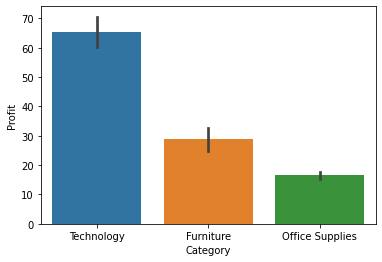

In [ ]:
sns.barplot(x="Category", y ="Profit", data=df)

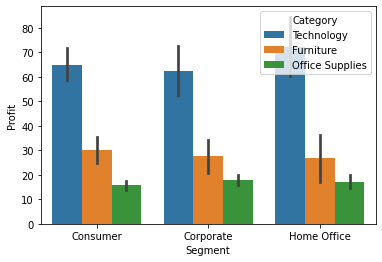

In [ ]:
sns.barplot(x="Segment", y ="Profit", hue="Category", data=df)

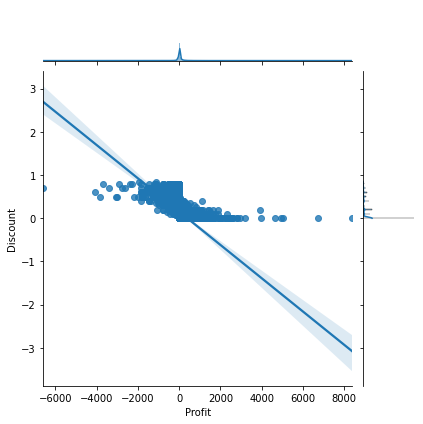

In [ ]:
sns.jointplot(x="Profit", y="Discount", data=df, kind="reg")

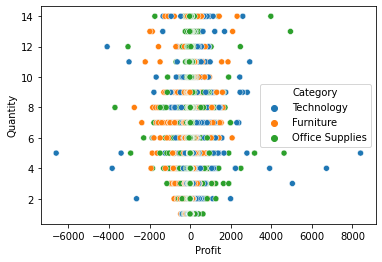

In [ ]:
sns.scatterplot(x="Profit", y ="Quantity", hue="Category", data=df)

In [ ]:
corr, _ = pearsonr(df['Profit'], df['Quantity'])
print('Pearson: %.3f' % corr)

Pearson: 0.104


In [ ]:
df.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

In [ ]:
df.nunique()

Row ID            51290
Order ID          25035
Order Date         1430
Ship Date          1464
Ship Mode             4
Customer ID        1590
Customer Name       795
Segment               3
City               3636
State              1094
Country             147
Postal Code         631
Market                7
Region               13
Product ID        10292
Category              3
Sub-Category         17
Product Name       3788
Sales             22995
Quantity             14
Discount             27
Profit            24575
Shipping Cost     10037
Order Priority        4
dtype: int64

### **Data Preprocessing**

In [ ]:
# Helper functions

# Convert date column into year, month and day columns 
def process_dates(df, column):
  data = df.copy()
  data[column] = pd.to_datetime(data[column])
  data[column + '_year'] = data[column].apply(lambda x : x.year)
  data[column + '_month'] = data[column].apply(lambda x : x.month)
  data[column + '_day'] = data[column].apply(lambda x : x.day)
  data.drop(column, axis=1, inplace=True)
  return data

# Converting categorical data 
def onehot_encode(df, column):
  data = df.copy()
  dummies = pd.get_dummies(data[column], prefix=column, drop_first=True)
  data = pd.concat([data, dummies],axis=1)
  data.drop(column, axis=1, inplace=True)
  return data

# Converting categorical data 
def onehot_encode_top(df, column, count):
  data = df.copy()
  top = [x for x in df[column].value_counts().sort_values(ascending=False).head(count).index ]
  for label in top:
    df[column+'_'+label] = np.where(df[column]==label, 1, 0)
  data.drop(column, axis=1, inplace=True)
  return data

# Converting categorical data 
def label_encode(df, column):
  data = df.copy()
  le = LabelEncoder()
  data[column] = le.fit_transform(data[column])
  return data

In [ ]:
def preprocess(df):
  data = df.copy()

  # Drop unnecessary columns
  data.drop(['Row ID','Order ID', 'Customer Name', 'Product Name', 'Ship Mode', 'City', 'State', 'Postal Code', 
              'Segment', 'Ship Date', 'Market', 'Order Priority', 'Quantity'], axis=1, inplace=True)

  # Extract date features
  data = process_dates(data, column='Order Date')

  # One-Hot Encoding
  for col in ['Region','Category', 'Sub-Category']: 
    data = onehot_encode(data, column=col)

  # One-Hot Encoding top_x values
  data = onehot_encode_top(data, column='Country', count=10)

  # Label Encoding
  for col in data.columns.values:
    if data[col].dtypes=='object':
      data = label_encode(data, column=col)  

  return data

In [ ]:
new_df = preprocess(df)
new_df.head(2)

,Customer ID,Product ID,Sales,Discount,Profit,Shipping Cost,Order Date_year,Order Date_month,Order Date_day,Region_Canada,Region_Caribbean,Region_Central,Region_Central Asia,Region_EMEA,Region_East,Region_North,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Category_Office Supplies,Category_Technology,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,1286,8246,2309.650,0.0,762.1845,933.57,2012,7,31,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,808,907,3709.395,0.1,-288.7650,923.63,2013,2,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### **Data Modelling**

In [ ]:
X = new_df.drop(columns='Profit')
y = new_df[['Profit']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38467, 38) (12823, 38) (38467, 1) (12823, 1)


**Linear Regression Algorithm**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
# y_test.head(5), y_pred[0:5]
# print(np.concatenate(y_test.reshape(len(y_test),1), y_pred.reshape(len(y_pred),1),1))
# model.score(X, y)

In [ ]:
r2_score(y_test, y_pred)

0.3407771259105845

**Random Forest Algorithm**

In [ ]:
# Scaling features
minmaxscaling = MinMaxScaler()
X_train_scaled = minmaxscaling.fit_transform(X_train)
X_test_scaled = minmaxscaling.transform(X_test)

In [ ]:
rf = RandomForestRegressor(random_state=24)
rf.fit(X_train_scaled,y_train)
predicted = rf.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# comparision_df = pd.DataFrame({'actual':y_test,'predicted':predicted})
# comparision_df
# y_test.head(), predicted[0:5]

In [ ]:
# rf.score(X_train_scaled,y_train)
# rf.score(X_test_scaled,y_test)

In [ ]:
r2_score(y_test, predicted)

0.7526396908529196